In [1]:
# This note book use nearest neighbor method(The most closest cell line) to predict CERES score of each gene. 

# Author: Yiyun

import pandas as pd
from os.path import join
import time
from scipy.spatial import distance
import seaborn as sns

In [2]:
# We first get the closets cell line from the Celligner in Depmap
celligner_dir = '../data/DepMap/celligner'
q3_dir = '../data/DepMap/19Q3'

In [3]:
# Read data
df_celligner = pd.read_csv(join(celligner_dir,'celligner_alignment.csv'),index_col = 0)
df_ref19q3 = pd.read_csv(join(q3_dir,'Achilles_gene_effect.csv'), index_col = 0)



# Check if the UMAP data is consistant as on the Celligner website
# df_cells.plot.scatter(x='UMAP_1',
#                       y='UMAP_2')

In [4]:
### Not all 19q3 cell lines are in celligner, we find nearest neighbors in 19q3 dataset
# Therefore the closest cell line is not necessarily the one in the Celligner

# Get only the cell line data in celligner
df_cells = df_celligner[df_celligner['sampleID'].str.startswith('ACH-')][['sampleID','UMAP_1','UMAP_2']]
df_cells = df_cells.transpose()
new_header = df_cells.iloc[0] 
df_cells = df_cells[1:] 
df_cells.columns = new_header 

In [5]:
# Select 19q3 cell line in Celligner cell lines, 3 cell lines are not found, process as missing data
cells_19q3 = df_ref19q3.index
cells_celligner = df_cells.columns

# Check if there's cell line in 19q3 not in celligner
cells_NF = [q3_cell for q3_cell in cells_19q3 if q3_cell not in cells_celligner]

# drop those cell lines from 19q3 list
cells_F = [q3_cell for q3_cell in cells_19q3 if q3_cell not in cells_NF]

In [26]:
# Select q3 cell line in celligner
df_cells = df_cells[cells_F]

In [37]:
### Calculate euclidean distance for each samples
df_close_cells = pd.DataFrame(index = ['closest_cell_line','distance'])

for cells in df_cells.columns:
    rest_cells = df_cells.columns.drop(cells)
    
    dist_0 = float(10000) # initiate a biggest value to find the smallest value
    close_cell = 'Random'
    for rest_cell in rest_cells:
        dist = distance.euclidean(df_cells[cells],df_cells[rest_cell])
        if dist <= dist_0:
            dist_0=dist
            close_cell = rest_cell
    df_close_cells[cells] = [close_cell,dist_0]

In [38]:
df_close_cells

,ACH-000004,ACH-000005,ACH-000007,ACH-000009,ACH-000011,ACH-000012,ACH-000013,ACH-000014,ACH-000015,ACH-000017,...,ACH-001715,ACH-001735,ACH-001736,ACH-001737,ACH-001740,ACH-001745,ACH-001750,ACH-001765,ACH-001814,ACH-001838
closest_cell_line,ACH-000005,ACH-000004,ACH-000820,ACH-000296,ACH-000234,ACH-000528,ACH-000293,ACH-000322,ACH-000221,ACH-000248,...,ACH-000673,ACH-001736,ACH-000782,ACH-000953,ACH-001765,ACH-001765,ACH-000133,ACH-001745,ACH-000082,ACH-000042
distance,0.230702,0.230702,0.709248,0.395715,0.212912,0.347879,0.206121,0.0550587,0.128074,0.325979,...,0.0737915,0.369783,0.274713,0.705307,0.716216,0.144185,0.257814,0.144185,0.10245,0.0516301


In [39]:
# df_close_cells.to_csv('nearest_neighbor_cell_dist.csv')

In [ ]:
# Create a prediction dataframe
index_cellline = df_ref19q3.index
column_genes = df_ref19q3.columns

df_prediction = pd.DataFrame(index = index_cellline, columns = column_genes)

In [ ]:
### Fill the prediction dataframe by the value of the closest cell line
### This part runs ~30min
for genes in column_genes:
    for cells in index_cellline:
        try:
            close_cellline = df_close_cells.loc[0,cells]
            pred_score = df_ref19q3.loc[close_cellline,genes]
            df_prediction.loc[cells,genes] = pred_score
        except KeyError:
            df_prediction.loc[cells,genes] = None

In [ ]:
# df_prediction

In [ ]:
# df_prediction.to_csv('prediction_040621.csv')

In [6]:
df_prediction = pd.read_csv('prediction_040621.csv', index_col = 0)

In [8]:
### correlation dataframe between actual and predicted, for every cell line
df_corr_cellline = pd.DataFrame(columns = ['cell_line','corr_sp','corr_pe'])

list_sp =[]; list_pe = []
for cell_lines in cells_F:
    df_score = pd.DataFrame(columns = ['actual','predicted'])
    score_actual = df_ref19q3.loc[cell_lines,:]
    score_predicted = df_prediction.loc[cell_lines,:]
    df_score['actual'] = score_actual
    df_score['predicted'] = score_predicted
#     ax = sns.regplot(x='actual', y='predicted',data = df_score)
    corr_sp = df_score['actual'].corr(df_score['predicted'],method = 'spearman')
    corr_pe = df_score['actual'].corr(df_score['predicted'],method = 'pearson')
    list_sp.append(corr_sp)
    list_pe.append(corr_pe)

df_corr_cellline['cell_line'] = cells_F; df_corr_cellline['corr_sp'] = list_sp; df_corr_cellline['corr_pe'] = list_pe

              actual  predicted
ACH-000004  0.168684  -0.068759
ACH-000005 -0.068759   0.168684
ACH-000007  0.053893   0.048482
ACH-000009  0.059874   0.078662
ACH-000011  0.277165   0.318330
...              ...        ...
ACH-001765  0.136364   0.208843
ACH-001814  0.216507   0.052705
ACH-001838 -0.086149   0.076815
ACH-001956 -0.076893        NaN
ACH-001957  0.055750        NaN

[625 rows x 2 columns]


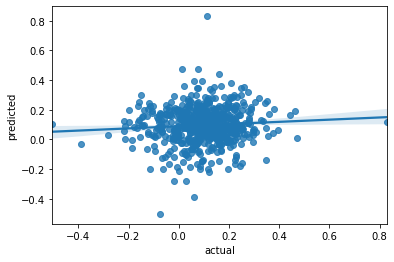

In [44]:
### Plot the correlation plot between actual and predicted, for every gene
df_corr_gene = pd.DataFrame(columns = ['gene','corr_sp','corr_pe'])

list_sp =[]; list_pe = []
n=0
for gene in df_prediction.columns:
    n+=1
    if n == 1:
        df_score = pd.DataFrame(columns = ['actual','predicted'])
        score_actual = df_ref19q3.loc[:,gene]
        score_predicted = df_prediction.loc[:,gene]
        df_score['actual'] = score_actual
        df_score['predicted'] = score_predicted
        print(df_score)
        ax = sns.regplot(x='actual', y='predicted',data = df_score)
        corr_sp = df_score['actual'].corr(df_score['predicted'],method = 'spearman')
        corr_pe = df_score['actual'].corr(df_score['predicted'],method = 'pearson')
        list_sp.append(corr_sp)
        list_pe.append(corr_pe)

In [21]:
df_corr_gene['gene'] = df_prediction.columns; df_corr_gene['corr_sp'] = list_sp; df_corr_gene['corr_pe'] = list_pe

In [23]:
# The mean spearman correlation across all genes
df_corr_gene['corr_sp'].mean()

0.040643303495763526

In [24]:
# The mean pearson correlation across all genes
df_corr_gene['corr_pe'].mean()

0.041398470963850305

In [40]:
df_corr_gene

,gene,corr_sp,corr_pe
0,A1BG (1),0.045787,0.074071
1,A1CF (29974),-0.005754,-0.056495
2,A2M (2),0.100579,0.074782
3,A2ML1 (144568),0.057937,0.057189
4,A3GALT2 (127550),0.005255,-0.013797
...,...,...,...
18328,ZYG11A (440590),0.107568,0.117498
18329,ZYG11B (79699),0.083490,0.120389
18330,ZYX (7791),0.079915,0.083616
18331,ZZEF1 (23140),0.131284,0.106524


In [41]:
# Save the correlation for each gene
# df_corr_gene.to_csv('nearest_neighbor_gene_corr_040921.csv', index = False)